In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import cv2
from glob import glob
import os
import re
import json
import torch
import detectron2
import warnings
warnings.filterwarnings("ignore")

color = (255, 0, 0)  
thickness = 2  


Populating the interactive namespace from numpy and matplotlib


In [145]:
from utils.make_dataset import *
from utils.transforms import *

In [146]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer

In [147]:
with open("meta-data.json", "r") as read_file:
    datset_info = json.load(read_file)
datset_info[0]

{'id': 'bd9d42ac-9952-4323-8fc6-5196e7440b7b',
 'archiveid': '5c654c0d-48ec-44a1-aaac-2477b29377ee',
 'pathologiesleft': ['cartialgeLession', 'boneMarrowLesion', 'synovitis'],
 'pathologiesright': ['noPathologies'],
 'visiblepart': 'L',
 'path': '/studies/5c654c0d-48ec-44a1-aaac-2477b29377ee/t2_tse_ax_384_fs',
 'mode': 'T2',
 'projection': 'Other',
 'metadata': {'patientAge': '026Y',
  'studyDate': 'Mon Feb 15 00:00:00 UTC 2021',
  'patientName': 'ANON0000',
  'manufacturerModelName': 'Verio',
  'manufacturer': 'SIEMENS',
  'patientSex': 'F',
  'modality': 'MR'},
 'isvalidated': True}

In [148]:
df_stats = pd.DataFrame(datset_info)

/studies/891d0e81-2f90-4aff-a5c2-c112e63bea55/t1_tse_COR_lymph-nodes
['cartialgeLession', 'synovitis']
['cartialgeLession', 'synovitis']
Cor_bilateral
B
T1


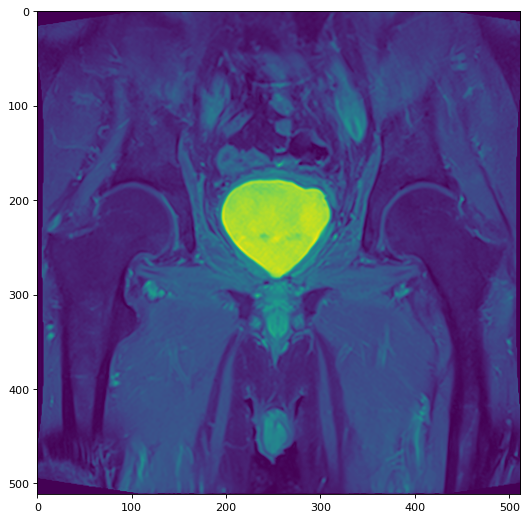

In [149]:
i = 127
path_folder = datset_info[i]['path']
plane = datset_info[i]['projection']
print(datset_info[i]['path'])
vis = datset_info[i]['visiblepart']
mode = datset_info[i]['mode']

path = os.path.join('validated', path_folder[1:])

scans = load_scan(path)
images = get_images(scans, resize=False)

figure(figsize=(8, 8), dpi=80)
n = 0
imgplot = plt.imshow( images[int(len(images)/2) + n])
#imgplot = plt.imshow( images[10][2] 
print(datset_info[i]['pathologiesleft'])
print(datset_info[i]['pathologiesright'])
print(plane)
print(vis)
print(mode)
plt.show()

In [150]:
PData = PreprocessedDatasetPart1()
data_list_p1 = PData.prepare(save_json=True)
#data_list_p1 = PData.make_in_memory_dataset(task = 'bone marrow lesion', projection = 'cor',
#                                         researh_types=['T2_FS', 'PD_FS', 'PD'], drop_types=['TRIM'],
#                                         resize = False, best_slice = False, crop = False)
#type(data_list[0]['box'][0])
len(data_list_p1)

376

In [8]:
figure(figsize=(8, 8), dpi=80)
images = data_list[0]['images'][:,0,:,:]
print(data_list[0]['researh_type'])
imgplot = plt.imshow(images[5] )
plt.show()

KeyError: 'images'

<Figure size 640x640 with 0 Axes>

In [83]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError
    
def get_desease_labels(desease_list): 
    
    
    labels = np.zeros(4)
    if 'cartialgeLession' in desease_list:
        labels[0] = 1
    if 'subchondralCyst' in desease_list:
        labels[1] = 1        
    if 'boneMarrowLesion' in desease_list:
        labels[2] = 1
    if 'synovitis' in desease_list:
        labels[3] = 1
    
    return np.uint8(labels)

def get_projection(row, root_folder, types_labels):
    path = os.path.join( root_folder, row[4][1:]) 
    if path in types_labels.keys():
        proj = types_labels[path]
        return proj
    else:
        return None
    
def get_bs(row, root_folder, new_bs):
    path = os.path.join( root_folder, row[4][1:]) 
    if path in new_bs.keys():
        bs = new_bs[path]
        return bs
    else:
        return None
    
def predict_box(image, projection):    
    
    if projection=='cor':
        #if image.shape[-1]!=256:
        #    image =  cv2.resize(image, (256,256))            
        image = np.stack((image, image, image), axis=-1)
        #image = np.moveaxis(image,0, -1)
        #print(image.shape)
        predictor = DefaultPredictor(cfg)
        outputs = predictor(image)  
        pred_boxes = outputs["instances"].to("cpu").pred_boxes[0].tensor.numpy()[0]    
    else:
        pred_boxes = None
        
    return pred_boxes

def bilateral(row,proj, root_folder, dataset_folder, i, predict, visible, new_bs): 
    
    elementL = {}
    elementR = {}
    element = {}

    path_folder = row['path']
    path = os.path.join( root_folder, path_folder[1:]) 
    scans = load_scan(path)


    try:
        images = get_images(scans, resize=False)            
    except ValueError:
        print('ValueError not loaded ', path)
        return None, None
    except AttributeError:
        print('AttributeError not loaded ', path)
        return None, None
    else:  
        
        imagesL, imagesR = split_in_half(images)
        npy_path1 = os.path.join( dataset_folder, '{}_L.npy'.format(i))
        npy_path2 = os.path.join( dataset_folder, '{}_R.npy'.format(i))
        element['orig_path'] = path
        element['best_slice'] = int(images.shape[0]/2)
        #element['box'] = box
        element['researh_type'] = row['mode']
        
        if proj =='Cor_bilateral':
            element['projection'] = 'cor'        
            
        labelsL = get_desease_labels(row['pathologiesleft'])     
        labelsR = get_desease_labels(row['pathologiesright'])  
        elementL, elementR = element.copy(), element.copy()
        elementL['side'], elementR['side'] = 'L', 'R'
        elementL['cartialge lesion'], elementR['cartialge lesion'] = labelsL[0], labelsR[0]
        elementL['subchondral cysts'], elementR['subchondral cysts'] = labelsL[1], labelsR[1]
        elementL['bone marrow lesion'], elementR['bone marrow lesion'] = labelsL[2], labelsR[2]
        elementL['synovitis'], elementR['synovitis'] = labelsL[3], labelsR[3]
        if 1 in labelsL:
            illL = 1
        else: 
            illL = 0

        if 1 in labelsR:
            illR = 1
        else: 
            illR = 0           
        elementL['ill'], elementR['ill'] = illL, illR       
        imagesL = normalize_images_v1(imagesL)
        imagesR = normalize_images_v1(imagesR)     
                   
        elementL['images'], elementR['images'] = imagesL, imagesR
            
        if predict:   
            boxL = predict_box(imagesL[element['best_slice']], element['projection']).tolist()
            boxR = predict_box(imagesR[element['best_slice']], element['projection']).tolist()
            elementL['box'], elementR['box'] = boxL, boxR

        elementL['path'], elementR['path'] = npy_path1 , npy_path2     


    return elementL, elementR

def single(row,proj, root_folder, dataset_folder, i, predict, visible, new_bs):     
  
    element = {}
    path_folder = row['path']
    path = os.path.join( root_folder, path_folder[1:])
    scans = load_scan(path)
    
        
    try:
        images = get_images(scans, resize=False)            
    except ValueError:
        print('ValueError not loaded ', path)
        return None
    except AttributeError:
        print('AttributeError not loaded ', path)
        return None
    else:        
        npy_path = os.path.join( dataset_folder, '{}_S.npy'.format(i))
        element['side'] = visible
        element['orig_path'] = path
        element['best_slice'] = int(images.shape[0]/2)
        #element['box'] = box
        element['researh_type'] = row['mode']   
        
        if proj =='Cor_left' or proj =='Cor_right':
            element['projection'] = 'cor'    
        if visible=='L':
            labels = get_desease_labels(row['pathologiesleft']) 
        elif visible=='R':
            labels = get_desease_labels(row['pathologiesright'])
        elif visible=='B':
            return None            
        else:
            print('not visible')
            return None      
        element['cartialge lesion'] = labels[0]
        element['subchondral cysts'] = labels[1]
        element['bone marrow lesion'] = labels[2]
        element['synovitis'] = labels[3]
        if 1 in labels:
            ill = 1
        else: 
            ill = 0            
        element['ill'] = ill        
        images = normalize_images_v1(images)
        element['images'] = images            
        if predict:
            box = predict_box(images[element['best_slice']], element['projection']).tolist()
            element['box'] = box                        
        element['path'] = npy_path
        
        if new_bs:
            element['best_slice'] = element['best_slice'] + new_bs
            
    return element

def save_as_npy(data_list, n):
    for i,element in enumerate(data_list):
        numpy.save(element['path'], element['images'])
        if i> n:
            break
        
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

def prepare_part2():    
    save_json = True
    with open("meta-data.json", "r") as read_file:
        datset_info = json.load(read_file)
    root_folder = 'validated'
    dataset_folder = 'data2'
    data_list = []
    predict = True
    length = 0
    projection_skip = 0
    projection_pass = 0
    
    for i, row in enumerate(datset_info):        
        element = {}
        proj = row['projection']
        
        if proj=='Cor_bilateral':  
            visible = 'B'
            elementL, elementR = bilateral(row,proj, root_folder, dataset_folder, i, predict, visible, new_bs= None)            
            if elementL and elementR:
                data_list.append(elementL)
                data_list.append(elementR)   
                length += 2                   
                projection_pass += 1
            else: print('L or R element is None')
                
        elif proj=='Cor_left':  
            visible = 'L'
            element = single(row, proj, root_folder, dataset_folder, i, predict, visible, new_bs = None)
            
            if element:
                data_list.append(element) 
                length += 1
                projection_pass += 1
            else: print('element is None')   
                
        elif proj=='Cor_right':
            visible = 'R'

            element = single(row, proj, root_folder, dataset_folder, i, predict, visible, new_bs= None)
            if element:
                data_list.append(element) 
                length += 1
                projection_pass += 1
                
            else: print('element is None')  
                
        else:
            projection_skip += 1
            continue
            
    print('Dataset len ',length)
    print('Studies passed ', projection_pass)
    print('Studies skipped ', projection_skip)
    print('Total studies ',i)


    if save_json:
        data_list_tosave = []
        for element in data_list: 
            element = removekey(element, 'images')
            data_list_tosave.append(element)
        with open('dataset_p2.json', 'w') as fp:
            json.dump(data_list_tosave, fp, default=convert) 
            
    return data_list

Loading config /home/teshbek/anaconda3/envs/mrnet/lib/python3.9/site-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [9]:
data_list = prepare_part2()

NameError: name 'prepare_part2' is not defined

In [71]:
save_as_npy(data_list, n=len(data_list)+1)

In [88]:
data_list_tosave = []
for element in data_list: 
    element = removekey(element, 'images')
    data_list_tosave.append(element)
    with open('dataset_p2.json', 'w') as fp:
        json.dump(data_list_tosave, fp, default=convert)    

In [89]:
len(data_list)

249

In [90]:
with open("dataset_p2.json", "r") as read_file:
    data_part2 = json.load(read_file)
len(data_part2)

249

In [91]:
data_part2[0]

{'side': 'L',
 'orig_path': 'validated/studies/dcf02fba-8b39-4179-b324-41def3e797e8/t1_se_cor_p2_384',
 'best_slice': 8,
 'researh_type': 'T1',
 'projection': 'cor',
 'cartialge lesion': 1,
 'subchondral cysts': 1,
 'bone marrow lesion': 0,
 'synovitis': 0,
 'ill': 1,
 'box': [98.3427505493164,
  84.81893157958984,
  266.0790710449219,
  280.50579833984375],
 'path': 'data2/1_S.npy'}

In [111]:
class PreprocessedDatasetFull():
    def __init__(self, part1_json='dataset_p1.json', part2_json='dataset_p2.json'):

        with open(part1_json, 'r') as read_file:
            self.data_part1_info = json.load(read_file)
        with open(part2_json, 'r') as read_file:
            self.data_part2_info = json.load(read_file)

    def make_in_memory_dataset(self, task, projection, researh_types, drop_types, crop=True, best_slice=True,
                               resize=True,
                               dim=(256, 256)):

        data_list = self.data_part1_info + self.data_part2_info

        data_list_images: List[Dict[str, Union[List[int], Any]]] = []

        for element in data_list:
            if element['projection'] != projection or not any(
                    [researh_type in element['researh_type'] for researh_type in researh_types]) or any(
                [drop_type in element['researh_type'] for drop_type in drop_types]):
                continue
            images = np.load(element['path'], allow_pickle=True)
            element['label'] = int(element[task])

            if crop:
                images = square_crop(images, element['box'])
            if best_slice:
                images = slice_crop(images, 0.3, element['best_slice'])
            if resize:
                images = resize_cv2(images, dim)

            #images = normalize_images_v2(images)
            # images = np.stack((images, contrast_stretch(images, n=2),equalize_clahe(images) ), axis=1)
            for i, img in enumerate(images):
                img = create_blur_mask(img)
                images[i] = img
            images = np.stack((images, images, images), axis=1)
            images = normalize_images_v1(images)
            element['images'] = images
            data_list_images.append(element)

        print(len(data_list_images), ' dataset length')

        return data_list_images

In [112]:
Dataset = PreprocessedDatasetFull()

data_list = Dataset.make_in_memory_dataset(task='bone marrow lesion', projection='cor', researh_types=['FS', 'fs', 'STIR', 'stir'],
                                                    drop_types=['TRIM'], crop=False, best_slice=False,
                                                    resize=False)
        

193  dataset length


./data2/286_S.npy
validated/studies/309f98ef-2bd3-4bfd-af24-83258e9563e3/t2_pdFS_384_cor
1
1
1
1
cor
cor
T2 FS


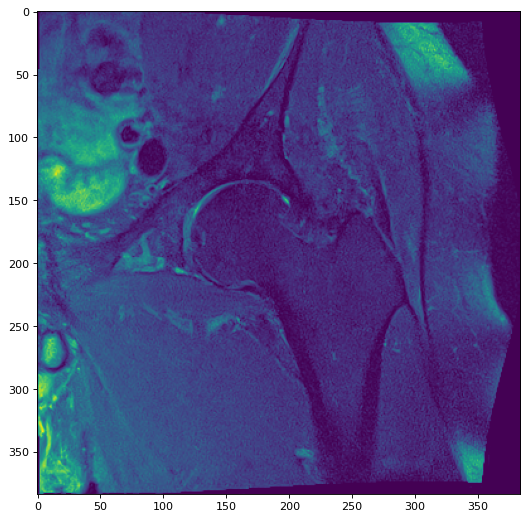

In [135]:
item = data_list[-7]
path = os.path.join('.', item['path'])
print(path)       
print(item['orig_path'])       
images = np.load(path)
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow( images[10])
print(item['cartialge lesion'])
print(item['subchondral cysts'])
print(item['bone marrow lesion'])
print(item['synovitis'])
print(item['projection'])
print(item['projection'])
print(item['researh_type'])

validated/studies/309f98ef-2bd3-4bfd-af24-83258e9563e3/t2_pdFS_384_cor
['cartialgeLession', 'subchondralCyst', 'boneMarrowLesion', 'synovitis']
['noPathologies']
Cor_left
L
T2 FS


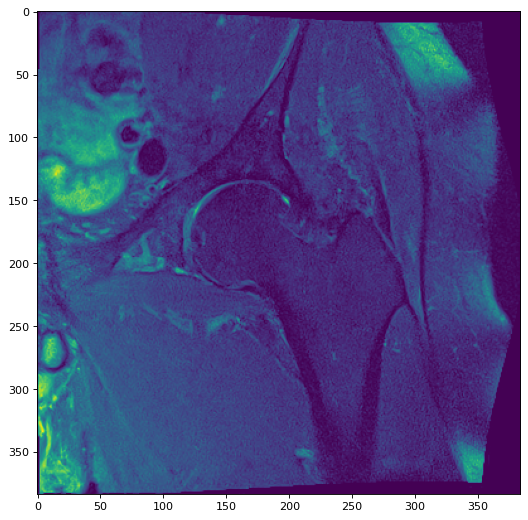

In [136]:
for item in datset_info:
    if item['path'] == '/studies/309f98ef-2bd3-4bfd-af24-83258e9563e3/t2_pdFS_384_cor':       
              
        path = os.path.join('validated', item['path'][1:])
        print(path) 
        scans = load_scan(path)
        images = get_images(scans, resize=False)
        figure(figsize=(8, 8), dpi=80)
        imgplot = plt.imshow( images[10])
        print(item['pathologiesleft'])
        print(item['pathologiesright'])
        print(item['projection'])
        print(item['visiblepart'])
        print(item['mode'])    

## PROJECTION LABELING

In [12]:
def prepare_sup():    
    projections = ['cor']
    save_json = True
    datset_info = pd.read_csv('meta-data.csv', header=None)
    root_folder = '.'
    dataset_folder = 'data2/supp_data'
    data_list = []
    predict = False
    
    for i, row in enumerate(datset_info.iloc):        
        element = {}
        visible = row[3]
        
        proj = 'SC'
        element = single(row,proj, root_folder, dataset_folder, i, predict, visible)
        if element:
            data_list.append(element) 
        else: print('element is None')        
                
    if save_json:
        data_list_tosave = []
        for element in data_list: 
            element = removekey(element, 'images')
            data_list_tosave.append(element)
        with open('dataset_supp.json', 'w') as fp:
            json.dump(data_list_tosave, fp, default=convert)            
    return data_list

In [13]:
#data_list_s = prepare_sup()

In [32]:
with open("dataset_supp.json", "r") as read_file:
    data_part2 = json.load(read_file)   

In [33]:
#save_as_npy(data_list_s, 1000)

PD
cor
'./studies/5e978e26-7cbd-49c8-8c42-3cc9f341ab1b/pd_spc_rst_cor_p2_iso_512':
data2/supp_data/330_S.npy


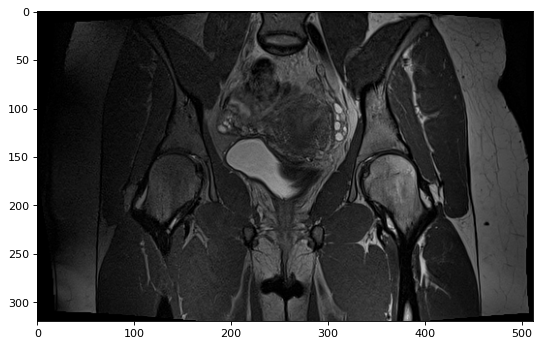

In [39]:
i = 324

#207
bs = data_part2[i]['best_slice']
images = np.load(data_part2[i]['path'])
images = np.stack((images, images,images), axis=3)
figure(figsize=(8, 8), dpi=80)
print(data_part2[i]['researh_type'])
print(data_part2[i]['projection'])
print("""'{}':""".format(data_part2[i]['orig_path']))
print(data_part2[i]['path'])
#bs = 2
image = images[bs]
imgplot = plt.imshow(image)
plt.show()

In [40]:
new_dataset = []

for item in data_part2[207:]:
    if (('fs' in item['orig_path']) or ('FS' in item['orig_path'])) and ('cor' in item['orig_path']):
        
        i+=1
        new_dataset.append(item)
print(i)

862


In [41]:
from PIL import Image, ImageDraw
from skimage import data, img_as_float, util
from skimage import exposure

T2 FS
cor
'./studies/83a15874-e0f7-401b-a55f-f4837570dc2c/t2_pdFS_384_cor':
data2/supp_data/970_S.npy


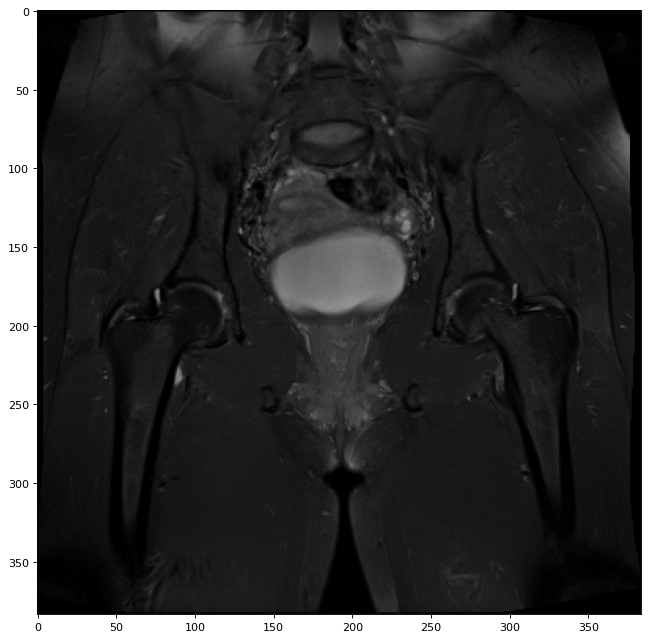

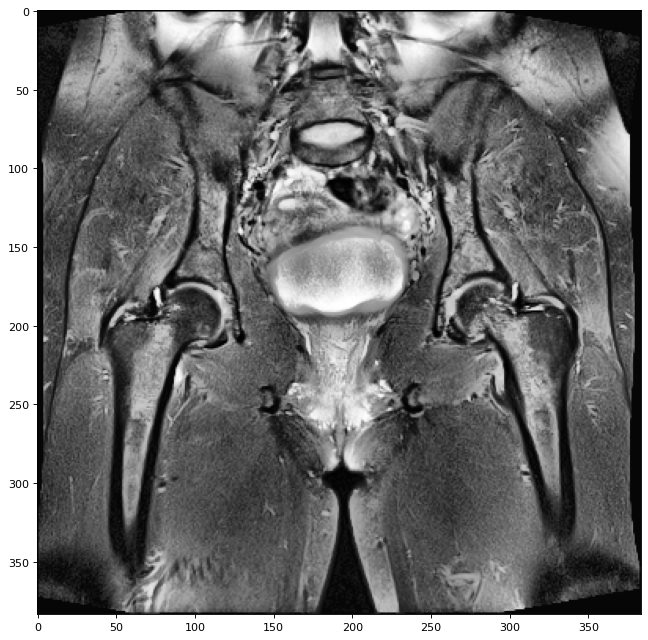

In [70]:
i = 137
bs = new_dataset[i]['best_slice'] 
images = np.load(new_dataset[i]['path'])
images = np.stack((images, images,images), axis=3)
print(new_dataset[i]['researh_type'])
print(new_dataset[i]['projection'])
print("""'{}':""".format(new_dataset[i]['orig_path']))
print(new_dataset[i]['path'])
#bs = 2
image = images[bs]
figure(figsize=(10, 10), dpi=80)
imgplot = plt.imshow(image)
plt.show()

image = exposure.equalize_adapthist(image, clip_limit=0.03)
figure(figsize=(10, 10), dpi=80)
imgplot = plt.imshow(image)
plt.show()

!rm data2/*.npy

In [15]:
with open('dataset_p2.json', 'r') as read_file:
    data_part2 = json.load(read_file)   

NameError: name 'data_list' is not defined

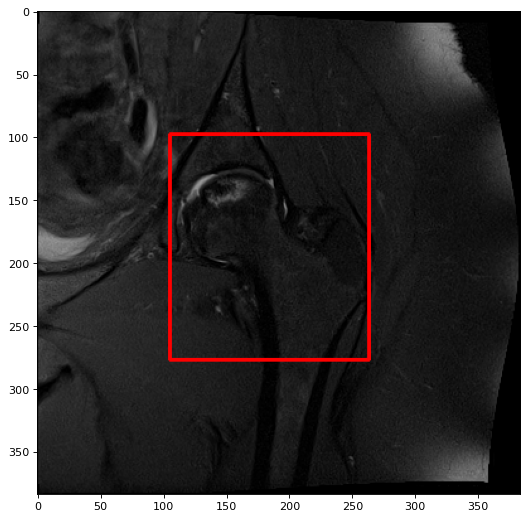

In [20]:
i = 5
bs = data_part2[i]['best_slice']
images = np.load(data_part2[i]['path'])
images = np.stack((images, images,images), axis=3)
figure(figsize=(8, 8), dpi=80)
image = images[bs]
pred_boxes = data_part2[i]['box']
image = cv2.rectangle(cv2.UMat(image) , (int(pred_boxes[0]),int(pred_boxes[1])) , (int(pred_boxes[2]),int(pred_boxes[3])),  color, thickness)
img_array = cv2.UMat.get(image)
imgplot = plt.imshow( img_array)
print(data_list[i]['researh_type'])
print(data_list[i]['projection'])
print("""'{}':""".format(data_part2[i]['orig_path']))
print(data_part2[i]['path'])
#mgplot = plt.imshow(image)
plt.show()